In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

In [120]:
#Tomar la dirección URL del archivo
url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Eval1/data/co2_smo_DailyData.txt'
my_cols_orig = ['0','year','month','day','hour','minute','second','1','CO2','2','3','4','5','6','7','8','9']
df_orig= pd.read_csv(url,names=my_cols_orig,encoding='cp1251',sep='\s+',header=None,skiprows=151,engine='python')
#print(df_orig)
df_2=df_orig.copy()
#Cambiamos los datos tipo fecha

df_2['Fecha']=pd.to_datetime(dict(day=df_2['day'],
                               month=df_2['month'],
                                 year=df_2['year']),
                             dayfirst=True)
#Parecer ser que le valio el formato de fecha
df_2.head()

#Se cambia los -999.99 por NaN 
str_Nan=-999.99
df_work00=df_2.replace(to_replace=str_Nan,value='NaN',regex=True)

#recortamos el periodo de principios de 1980 a 2019
df_work0=df_work00[(df_work00['year']>=1980)& (df_work00['year']<=2019)]
#print(df_work0.head())
#print(df_work0.tail())

#Creamos el data frame que tenga solo las dos columnas que nos interesan
df_work1=df_work0[['Fecha','CO2']]
df_work1.head()

#Hacemos que el indice sea la fecha
df_work1= df_work1.set_index('Fecha')
df_work1.head()

#Se menciona que podemos usar la funcion para rellenar hacia enfrente los 
#valores vacios en base al ultimo valor anterior posible

df_work1.ffill(axis=0,inplace=True)
#Ahora solo convertimos los datos a numeros flotantes
df_work1['CO2']=pd.to_numeric(df_work1['CO2'],errors='coerce')

ts_test=df_work1.copy()
ts_test.ffill(axis=0,inplace=True)
ts_test.info()
print(ts_test.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14610 entries, 1980-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO2     14610 non-null  float64
dtypes: float64(1)
memory usage: 228.3 KB
               CO2
Fecha             
1980-01-01  337.25
1980-01-02  337.25
1980-01-03  337.56
1980-01-04  337.69
1980-01-05  337.83


In [122]:
#Creamos una funcion para probar la estacionaridad de la serie de tiempo
def test_stationarity(df_ts):
  #Determina la estadistica de promedios moviles
  rolmean = df_ts.rolling(window=365,center=True).mean()
  rolstd= df_ts.rolling(window=365,center=True).std()

  #Define el tamaño de la figura 
  plt.rcParams['figure.figsize']=(12,6)
  #Graficando las estadisticas de los promedios moviles
  plt.plot(df_ts,color='cyan',label='Original')
  plt.plot(rolmean,color='red',label='Rolling mean')
  plt.plot(rolstd,color='green',label='Rolling std deviation')

  plt.legend(loc='best')
  plt.title('Promedio movil y desviacion estandar')
  plt.grid()
  plt.show()

  #Realizara la prueba aumentada de dickey -fuller
  print('Resultados de la prueba de Dickey-Fuller: ')
  dftest = adfuller(df_ts , autolag='AIC')
  dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value',
                                        '#Lags Used','Number of Observatons Used'])
  for key, value in dftest[4].items():
    dfoutput['Critical Value(%s)'%key]= value
  print(dfoutput)


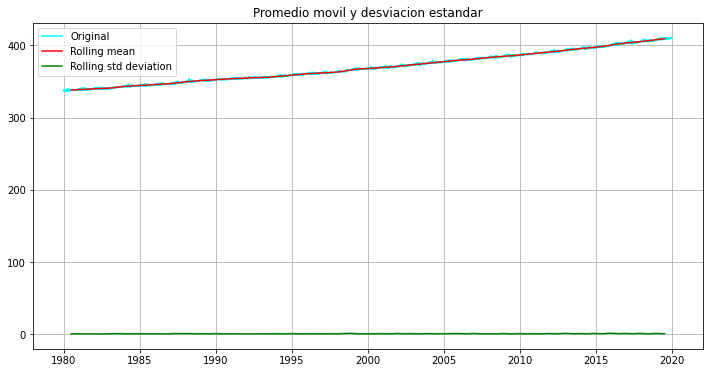

Resultados de la prueba de Dickey-Fuller: 
Test Statistic                    1.351348
p-value                           0.996882
#Lags Used                       39.000000
Number of Observatons Used    14570.000000
Critical Value(1%)               -3.430799
Critical Value(5%)               -2.861738
Critical Value(10%)              -2.566876
dtype: float64


In [155]:
test_stationarity(ts_test['CO2'])

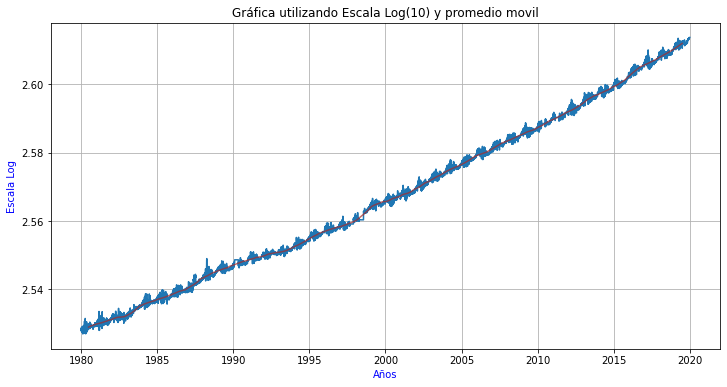

In [156]:
ts_test_log = np.log10(ts_test)
moving_avg = ts_test_log.rolling(365,center=True).mean()
plt.plot(ts_test_log)
plt.plot(moving_avg, color = 'brown',alpha=0.7)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10) y promedio movil')
plt.grid()
plt.show();

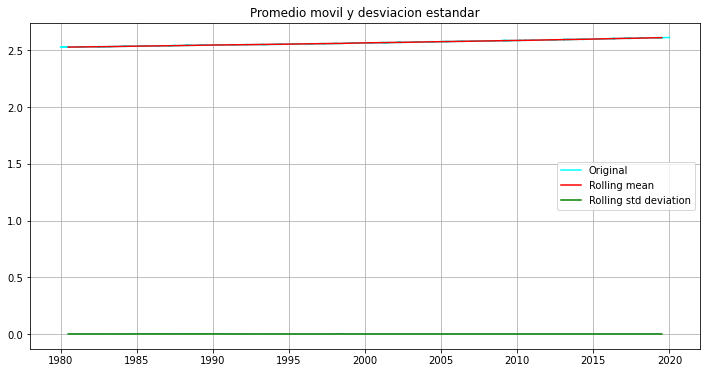

Resultados de la prueba de Dickey-Fuller: 
Test Statistic                    0.853140
p-value                           0.992447
#Lags Used                       35.000000
Number of Observatons Used    14574.000000
Critical Value(1%)               -3.430799
Critical Value(5%)               -2.861738
Critical Value(10%)              -2.566876
dtype: float64


In [125]:
test_stationarity(ts_test_log['CO2'])

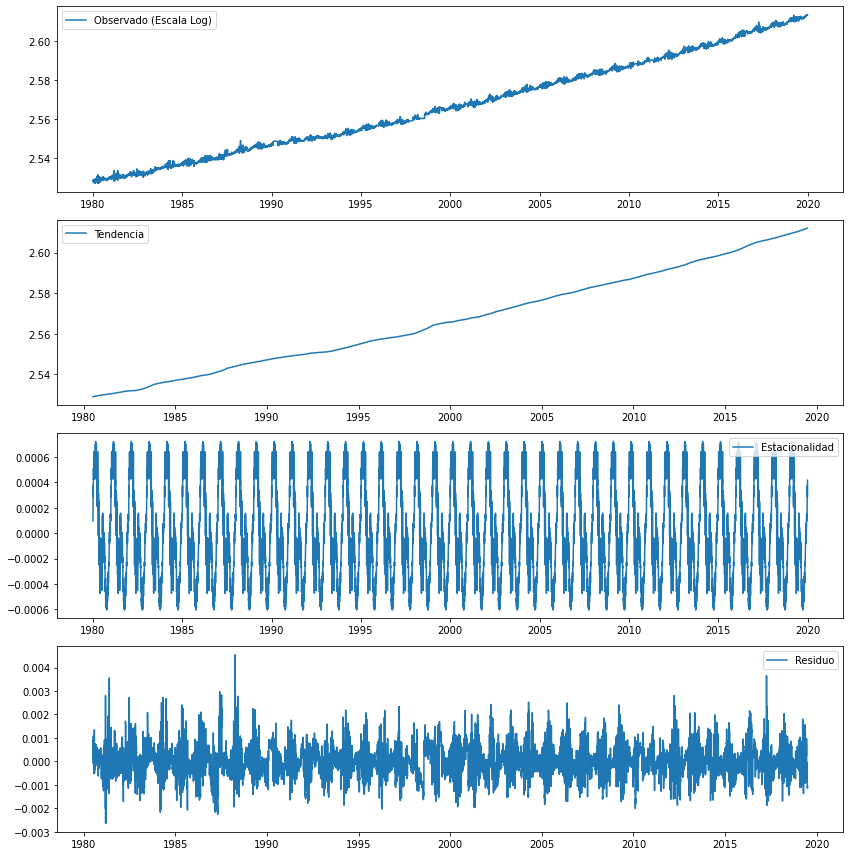

In [126]:
decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(),
                                          model='additive', freq=365)
# La función regresa 3 componentes: tendencia, estacionalidad y un residuo
trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid
# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')
# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

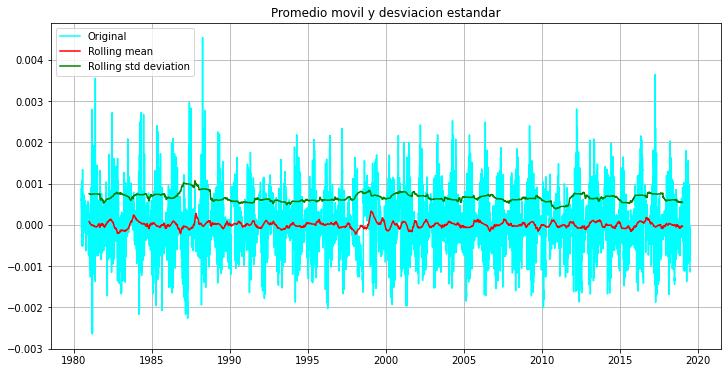

Resultados de la prueba de Dickey-Fuller: 
Test Statistic               -1.815980e+01
p-value                       2.463081e-30
#Lags Used                    2.100000e+01
Number of Observatons Used    1.422400e+04
Critical Value(1%)           -3.430810e+00
Critical Value(5%)           -2.861743e+00
Critical Value(10%)          -2.566878e+00
dtype: float64


In [127]:
ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
ts_test_log_decompose .head()
test_stationarity(ts_test_log_decompose['CO2'])

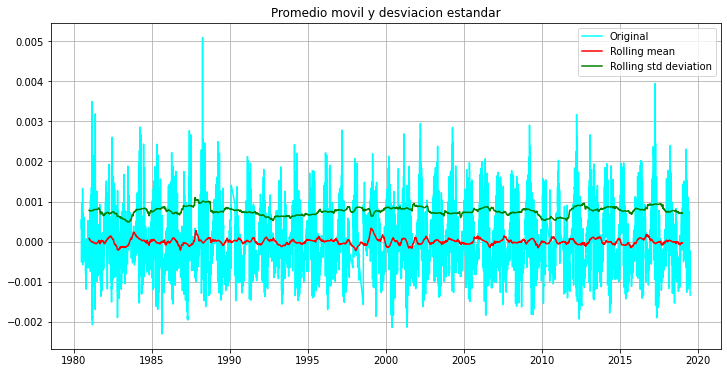

Resultados de la prueba de Dickey-Fuller: 
Test Statistic               -1.280448e+01
p-value                       6.645984e-24
#Lags Used                    2.800000e+01
Number of Observatons Used    1.421700e+04
Critical Value(1%)           -3.430810e+00
Critical Value(5%)           -2.861743e+00
Critical Value(10%)          -2.566878e+00
dtype: float64


In [128]:
ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.head()
#Hay NaN
ts_test_log_moving_ave_diff.dropna(inplace=True)
ts_test_log_moving_ave_diff.head()
#Corregido
test_stationarity(ts_test_log_moving_ave_diff['CO2'])

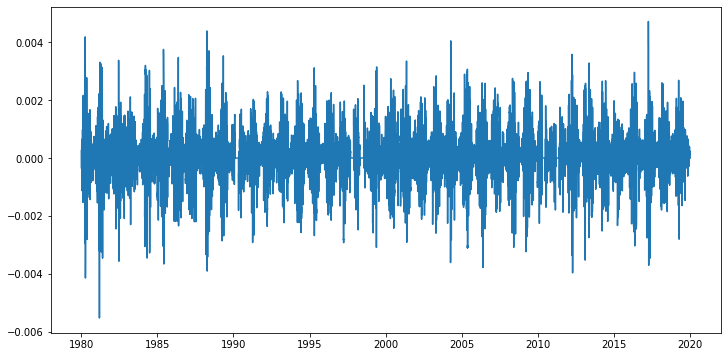

In [129]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
ts_test_log_diff .dropna(inplace=True)
plt.plot(ts_test_log_diff);

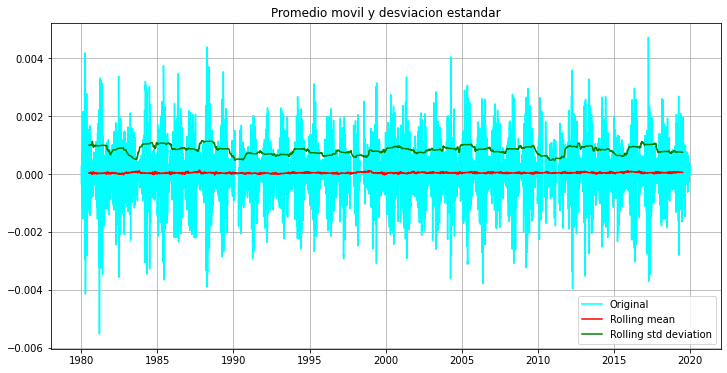

Resultados de la prueba de Dickey-Fuller: 
Test Statistic                  -22.689055
p-value                           0.000000
#Lags Used                       42.000000
Number of Observatons Used    14560.000000
Critical Value(1%)               -3.430799
Critical Value(5%)               -2.861739
Critical Value(10%)              -2.566876
dtype: float64


In [130]:
test_stationarity(ts_test_log_diff['CO2'])

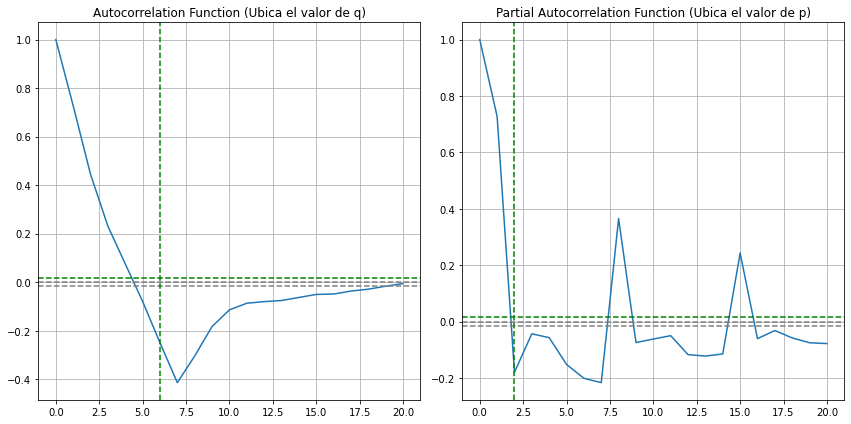

In [131]:
lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias

plt.axvline(x=6, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.CO2   No. Observations:                14609
Model:                 ARIMA(2, 1, 0)   Log Likelihood               92545.287
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -185082.574
Time:                        07:28:23   BIC                        -185052.217
Sample:                    01-02-1980   HQIC                       -185072.489
                         - 12-31-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.867e-06   3.09e-06      1.897      0.058   -1.94e-07    1.19e-05
ar.L1.D.CO2    -0.0003      0.008     -0.033      0.974      -0.016       0.016
ar.L2.D.CO2    -0.1478      0.008    -18.063    

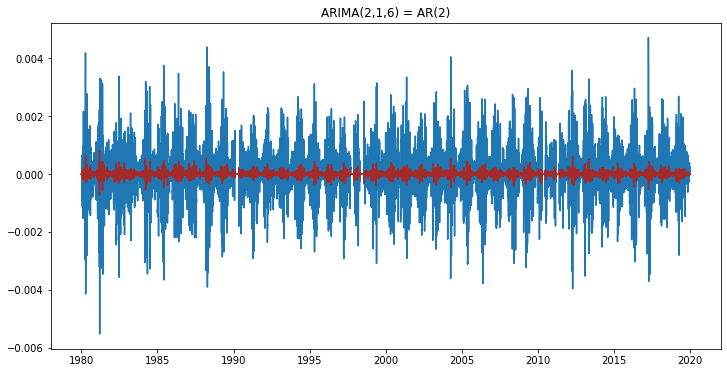

In [132]:
# Modelo AR(p): (p,d,q) = (2,1,6) 
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,6) = AR(2)')
print(results_AR.summary())

In [144]:
AIC_AR= -185082.574

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.CO2   No. Observations:                14609
Model:                 ARIMA(0, 1, 6)   Log Likelihood               93106.732
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -186197.465
Time:                        07:29:17   BIC                        -186136.750
Sample:                    01-02-1980   HQIC                       -186177.294
                         - 12-31-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.851e-06   9.25e-07      6.325      0.000    4.04e-06    7.66e-06
ma.L1.D.CO2    -0.0548      0.009     -6.275      0.000      -0.072      -0.038
ma.L2.D.CO2    -0.1867      0.008    -22.689    

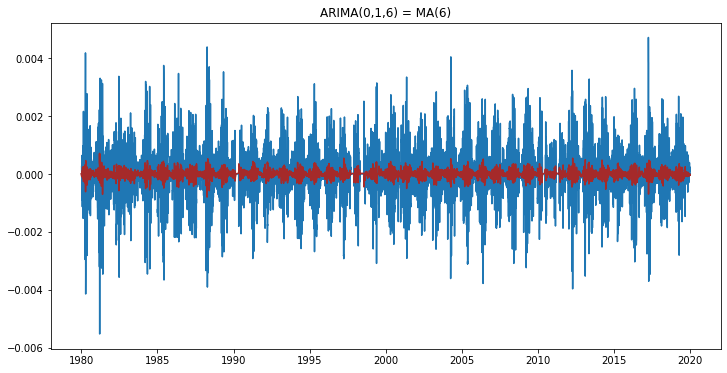

In [134]:
# Modelo MA(q): (p,d,q) = (2,1,6) 
model = ARIMA(ts_test_log, order=(0,1,6), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,6) = MA(6)')
print(results_MA.summary())

In [143]:
AIC_MA=-186197.465

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


                             ARIMA Model Results                              
Dep. Variable:                  D.CO2   No. Observations:                14609
Model:                 ARIMA(2, 1, 6)   Log Likelihood               93156.492
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -186292.983
Time:                        07:30:49   BIC                        -186217.089
Sample:                    01-02-1980   HQIC                       -186267.770
                         - 12-31-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.849e-06   7.71e-07      7.587      0.000    4.34e-06    7.36e-06
ar.L1.D.CO2     0.1825        nan        nan        nan         nan         nan
ar.L2.D.CO2     0.1382        nan        nan    

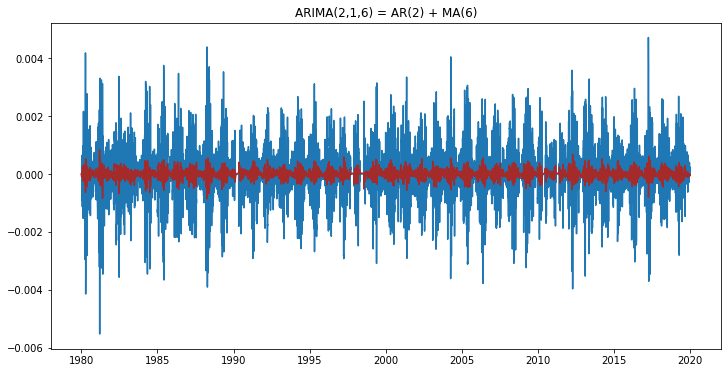

In [136]:
# Modelo ARIMA(p): (p,d,q) = (2,1,6) 
model = ARIMA(ts_test_log, order=(2,1,6), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,6) = AR(2) + MA(6)')
print(results_ARIMA.summary())

In [147]:
AIC_ARIMA=-186292.983

In [148]:
print('AIC_AR: ',AIC_AR,'AIC_MA: ',AIC_MA,'AIC_ARIMA: ',AIC_ARIMA)

AIC_AR:  -185082.574 AIC_MA:  -186197.465 AIC_ARIMA:  -186292.983


In [149]:
# Se define una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Fecha
1980-01-02    0.000006
1980-01-03    0.000006
1980-01-04    0.000008
1980-01-05   -0.000053
1980-01-06   -0.000076
dtype: float64

In [150]:
# Se suman las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log = pd.Series(ts_test_log['CO2'], index = ts_test_log.index)

predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print('Ts_test:')
print(ts_test_log.head())
print('Predictions_Arima_log')
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())

Ts_test:
                 CO2
Fecha               
1980-01-01  2.527952
1980-01-02  2.527952
1980-01-03  2.528351
1980-01-04  2.528518
1980-01-05  2.528698
Predictions_Arima_log
Fecha
1980-01-01         NaN
1980-01-02    2.527958
1980-01-03    2.528357
1980-01-04    2.528526
1980-01-05    2.528645
dtype: float64
Fecha
2019-12-27    2.613693
2019-12-28    2.613697
2019-12-29    2.613701
2019-12-30    2.613705
2019-12-31    2.613708
dtype: float64


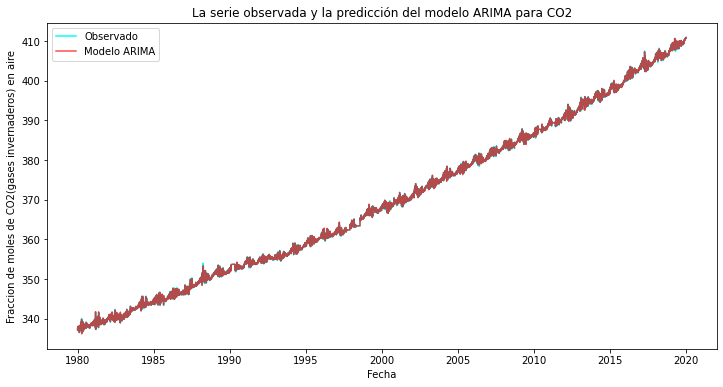

In [151]:
# la escala de Temperatura origina seríal 
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test, label='Observado',color='cyan');
plt.plot(predictions_ARIMA, label='Modelo ARIMA',color='red',alpha=0.7);
plt.xlabel('Fecha')
plt.ylabel('Fraccion de moles de CO2(gases invernaderos) en aire')
#Si mal no entiendo esto es lo que dice 
#(10-6 mol per mol of dry air); abbreviated as ppm (parts per million).
plt.title('La serie observada y la predicción del modelo ARIMA para CO2')
plt.legend(loc='best')

In [152]:
# Calculames el RMSE  
#- Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test['CO2'])**2))
print('RMSE:', RMSE)

RMSE: 0.11640616196215715


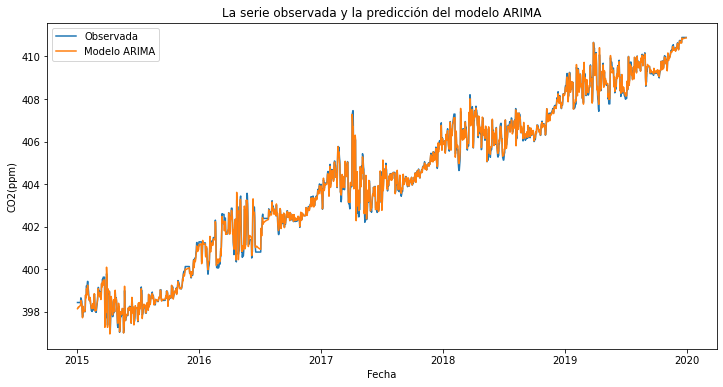

In [153]:
ts_test_last = ts_test.tail(1825)
predictions_ARIMA_last = predictions_ARIMA.tail(1825)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('CO2(ppm)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');

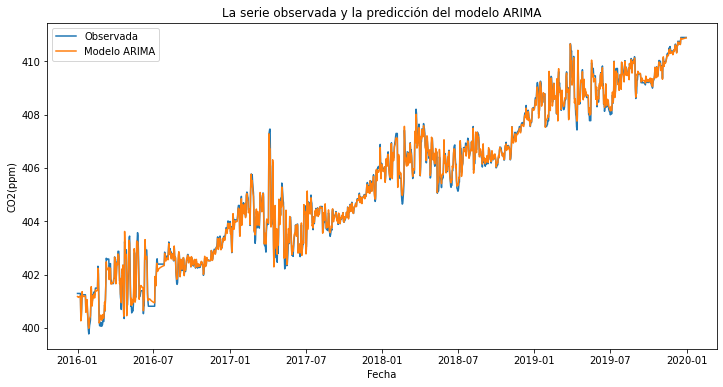

In [154]:
ts_test_last = ts_test.loc['2016-01-01':'2019-12-31']
predictions_ARIMA_last = predictions_ARIMA.loc['2016-01-01':'2019-12-31']
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('CO2(ppm)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');